# Human-In-Context: Body pose

In this notebook, we will show how to visualize the body skeleton from HIC data

# Imports

In [28]:
import random
from os.path import join
import numpy as np
import json
import matplotlib.pyplot as plt
import cv2
from helpers import imshow

random.seed(151)

## Files loading

In [30]:
DATA_PATH = '../HIC Data/frames/004/media_dashboard_camera'
RGB_IMG_PATH = join(DATA_PATH, 'visible_spectrum.png')
BODY_KPTS_PATH = join(DATA_PATH, 'key_points', 'body_key_points.json')
HANDS_KPTS_PATH = join(DATA_PATH, 'key_points', 'hands_key_points.json')


with open(BODY_KPTS_PATH) as f:
    body_dict = json.load(f)['body']

with open(HANDS_KPTS_PATH) as f:
    hands_dict = json.load(f)['hands']


## Data Pre-processing

Recursively extract the relevant data from the dictionary and format it as a numpy array

In [31]:
def filter_2d(d):
    if 'pixel_2d' in d.keys():
        return np.array([d['pixel_2d']['x'], d['pixel_2d']['y']])
    else:
        new_d = {}
        for key, value in d.items():
            new_d[key] = filter_2d(value)
        return new_d

body_dict = filter_2d(body_dict)
hands_dict = filter_2d(hands_dict)

Let's create a simple tree implementation for the skeleton's kinematic tree

In [ ]:
class Node:
    def __init__(self, data, children=None):
        self.data = data
        if children is not None:
            self.children = children
        else:
            self.children = []

We'll now build the body's kinematic tree

In [32]:
for side in ('left', 'right'):
    get_finger_tree = lambda finger : Node(finger['mcp'], [Node(finger['pip'], [Node(finger['dip'], [Node(finger['tip'])])])])
    
    # We begin with building the kinematic tree of each of the fingers separately
    fingers_dict = hands_dict[side]['finger']
    thumb_dict = fingers_dict['thumb']
    thumb = Node(thumb_dict['cmc'], [Node(thumb_dict['mcp'], [Node(thumb_dict['ip'], [Node(thumb_dict['tip'])])])])
    index = get_finger_tree(fingers_dict['index'])
    middle = get_finger_tree(fingers_dict['middle'])
    ring = get_finger_tree(fingers_dict['ring'])
    pinky = get_finger_tree(fingers_dict['pinky'])

    # We can build the hand tree from all of the fingers
    hand = Node(hands_dict[side]['wrist'], [thumb, index, middle, ring, pinky])

    # We do the same with arms, legs and eyes
    arm = Node(body_dict['shoulder'][side], [Node(body_dict['elbow'][side], [Node(body_dict['wrist'][side])])])
    leg = Node(body_dict['hip'][side], [Node(body_dict['knee'][side], [Node(body_dict['ankle'][side], [Node(body_dict['foot'][side]['index'])])])])

    eye_dict = body_dict['eye'][side]
    eye = Node(eye_dict['center'], [Node(eye_dict['outer']), Node(eye_dict['inner']), Node(body_dict['ear'][side])])

    if side == 'left':
        left_hand = hand
        left_arm = arm
        left_leg = leg
        left_eye = eye
    elif side == 'right':
        right_hand = hand
        right_arm = arm
        right_leg = leg
        right_eye = eye

# We create two new nodes at the center of the shoulders and the hips
hips_center_position = np.mean([left_leg.data, right_leg.data], axis=0).astype('int')
shoulders_center_position = np.mean([left_arm.data, right_arm.data], axis=0).astype('int')

# We can finally create the whole body and face trees
lower_body = Node(hips_center_position, [left_leg, right_leg])
body = Node(shoulders_center_position, [lower_body, left_arm, right_arm])
mouth = Node(body_dict['mouth']['left'], [Node(body_dict['mouth']['right'])])
upper_face = Node(body_dict['nose'], [left_eye, right_eye])

## Skeleton visualization

Now that we have the kinematic tree, drawing the skeleton is straightforward.<br>
<b>draw_skeleton</b> is a function that recursively draws the links between a node and its children

In [33]:
nrof_colors = 30
cmap = plt.cm.get_cmap('nipy_spectral', nrof_colors)
def draw_skeleton(img, node, thickness, cmap_idx=0):
    for child in node.children:
        color = (np.array(cmap(cmap_idx % nrof_colors))[:3]*255).astype('int').tolist()
        cmap_idx += 1
        cv2.line(img, np.flip(node.data), np.flip(child.data), color=color, thickness=thickness, lineType=cv2.LINE_AA)
        draw_skeleton(img, child, thickness, cmap_idx+1)

We load the image and draw the different parts of the skeletons separately

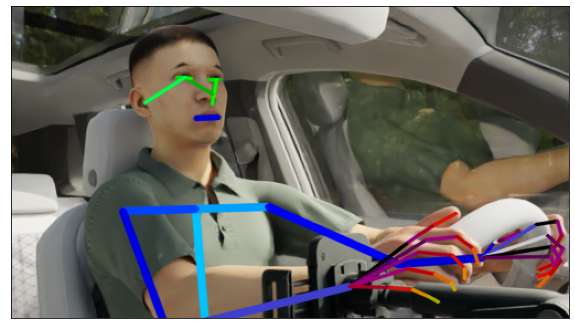

In [34]:
img = cv2.imread(RGB_IMG_PATH)

draw_skeleton(img, body, 5, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, upper_face, 2, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, mouth, 3, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, left_hand, 2, cmap_idx=random.randint(0, nrof_colors))
draw_skeleton(img, right_hand, 2, cmap_idx=random.randint(0, nrof_colors))

imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

## Body keypoints

Alternatively, we can choose to draw only the keypoints without the skeleton. The procedure is similar:

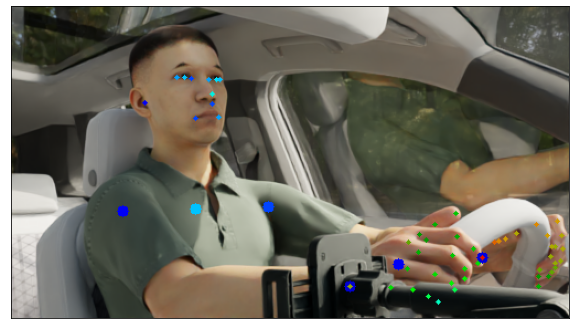

In [35]:
def draw_keypoints(img, node, thickness, cmap_idx=0):
    color = (np.array(cmap(cmap_idx % nrof_colors))[:3]*255).astype('int').tolist()
    cv2.circle(img, np.flip(node.data), thickness, color, -1)
    for child in node.children:
        cmap_idx +=1
        draw_keypoints(img, child, thickness, cmap_idx)


img = cv2.imread(RGB_IMG_PATH)

draw_keypoints(img, body, 5, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, upper_face, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, mouth, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, left_hand, 2, cmap_idx=random.randint(0, nrof_colors))
draw_keypoints(img, right_hand, 2, cmap_idx=random.randint(0, nrof_colors))

imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))